# Group Project: Fitness Activity Video Classification

Author: Matthieu Beylard

## Imports

In [12]:
import numpy as np
import pandas as pd
import imageio
import json
import cv2
import ast
import glob
import os
import re
import PIL
import tqdm
import pathlib
import warnings
import ffmpeg

import mediapy as media

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from tensorflow_docs.vis import embed
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

from IPython.display import display, HTML, clear_output

from pycocotools.coco import COCO

mpl.rcParams.update({
    'font.size': 10,
})

# Task 1: Keypoint Detection (using MoveNet)

In [2]:
# Initialize TFLite interpreter
interpreter = tf.lite.Interpreter(model_path='movenet_lightning.tflite')
interpreter.allocate_tensors()

# Extract keypoints with scores from a video
def extract_keypoints(video_path):
    keypoints_with_scores = []

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    while cap.isOpened():
        ret, frame = cap.read()

        # Break if the end of the video is reached
        if not ret:
            break
        
        # Reshape image
        img = frame.copy()
        img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 192, 192)
        input_image = tf.cast(img, dtype=tf.float32)
        
        # Setup input and output 
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        
        # Make predictions 
        interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
        interpreter.invoke()
        keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])

    cap.release()

    return keypoints_with_scores

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### Generate Dataframe with relevant informations for Keypoint Detection

In [3]:
# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

In [4]:
# Initialize an empty list to store data for DataFrame
data = []

# List of activities
activities = ["bicyclecrunch", "birddog", "fly", "legraise", "curl", "armraise", "pushup", "superman", "overheadpress", "squat"]

for label, activity in enumerate(activities):
    # Output folder
    output_path = f"FitnessBasic/{activity}/output/"
    os.makedirs(output_path, exist_ok=True)

    # List of subject names
    subject_names = [f"{i:06d}" for i in range(100)]

    # Loop over each subject
    for subject_name in subject_names:

        # Extract keypoints from the video
        video_path = f"FitnessBasic/{activity}/data/{subject_name}.mp4"

        # Open the video file
        cap = cv2.VideoCapture(video_path)

        # Loop over each frame
        frame_count = 1
        while cap.isOpened():
            ret, frame = cap.read()
            
            # Break if the end of the video is reached
            if not ret:
                break
            
            keypoints_data = {
                "Video ID": f"{activity}_{subject_name}",
                "Frame": frame_count,
                "Label": label
            }

            # Resize and preprocess the frame
            img = tf.image.resize_with_pad(np.expand_dims(frame, axis=0), 192, 192)
            input_image = tf.cast(img, dtype=tf.float32)

            # Set up input and output details
            input_details = interpreter.get_input_details()
            output_details = interpreter.get_output_details()

            # Make predictions
            interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
            interpreter.invoke()
            keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])

            # List of keypoints
            keypoints = ["nose", "left_eye", "right_eye", "left_ear", "right_ear", "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
                         "left_wrist", "right_wrist", "left_hip", "right_hip", "left_knee", "right_knee", "left_ankle", "right_ankle"]

            # Loop over each keypoint
            for keypoint in keypoints:
                # Get the index of the keypoint from the keypoint dictionary
                kp_index = KEYPOINT_DICT[keypoint]
                # Extract the coordinates and score for the keypoint
                kp_data = keypoints_with_scores[0][0][kp_index]
                # Separate y-coordinate, x-coordinate, and confidence value
                y, x, c = kp_data
                # Add the keypoint data to the keypoints_data dictionary
                keypoints_data[f"{keypoint}_y"] = y
                keypoints_data[f"{keypoint}_x"] = x
                keypoints_data[f"{keypoint}_c"] = c

            data.append(keypoints_data)
            frame_count += 1

# Create DataFrame from the list of dictionaries
df = pd.DataFrame(data)

# Save DataFrame to CSV
df.to_csv("keypoints_data_movenet.csv", index=False)

df.head()

,Video ID,Frame,Label,nose_y,nose_x,nose_c,left_eye_y,left_eye_x,left_eye_c,right_eye_y,...,left_knee_c,right_knee_y,right_knee_x,right_knee_c,left_ankle_y,left_ankle_x,left_ankle_c,right_ankle_y,right_ankle_x,right_ankle_c
0,bicyclecrunch_000000,1,0,0.803412,0.655058,0.159575,0.730574,0.755231,0.131068,0.729917,...,0.057550,0.815933,0.597457,0.123030,0.838352,0.607253,0.103030,0.805962,0.622200,0.090445
1,bicyclecrunch_000000,2,0,0.854772,0.698136,0.314418,0.844347,0.698885,0.223878,0.837882,...,0.022504,0.975948,0.566701,0.040964,0.983131,0.567528,0.028624,0.986153,0.563614,0.032275
2,bicyclecrunch_000000,3,0,0.795881,0.722928,0.272604,0.792614,0.720442,0.250976,0.797852,...,0.079751,0.864393,0.687863,0.117492,0.861766,0.693838,0.073343,0.865666,0.687521,0.077274
3,bicyclecrunch_000000,4,0,0.830434,0.703526,0.256860,0.811854,0.709946,0.264242,0.812486,...,0.038146,0.912905,0.688764,0.042666,0.980325,0.680784,0.020093,0.982657,0.675419,0.020893
4,bicyclecrunch_000000,5,0,0.808726,0.718333,0.247153,0.793587,0.720442,0.255866,0.794402,...,0.051800,0.912975,0.685661,0.055291,0.983919,0.702666,0.022456,0.984723,0.658350,0.022874


### Preprocess Dataframe for CNN/LSTM model

In [5]:
# Load the dataset
df = pd.read_csv("keypoints_data_movenet.csv")

# Extract input sequences (keypoints) and labels
input_sequences = []
labels = []

for index, row in df.iterrows():
    # Extract keypoints for the current video
    keypoints_columns = [col for col in df.columns if col not in ["Video ID", "Frame", "Label"]]
    
    # Concatenate keypoints from all columns into a single sequence
    sequence = []
    for col in keypoints_columns:
        sequence.extend([row[col]])
        
    # Append the input sequence
    input_sequences.append(sequence)
    
    # Append the label
    labels.append(row["Label"])

### Run the CNN model

In [6]:
# Convert input_sequences to numpy array
X_train = np.array(input_sequences)

# Reshape X_train for the CNN model
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Train-Test split the data
X_train, X_test, y_train, y_test = train_test_split(X_train_reshaped, labels, test_size=0.33, random_state=1)

# Convert y_train to numpy array if it's not already
y_train = np.array(y_train)

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the input sequences
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=1)

# Design the CNN model
model = Sequential([
    layers.Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.GlobalAveragePooling1D(), 
    layers.Dense(len(activities), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
5728/5728 [==============================] - 15s 3ms/step - loss: 1.3737 - accuracy: 0.4374 - val_loss: 1.1658 - val_accuracy: 0.5301
Epoch 2/20
5728/5728 [==============================] - 14s 2ms/step - loss: 1.0332 - accuracy: 0.5887 - val_loss: 0.9571 - val_accuracy: 0.6200
Epoch 3/20
5728/5728 [==============================] - 16s 3ms/step - loss: 0.8583 - accuracy: 0.6685 - val_loss: 0.7995 - val_accuracy: 0.6930
Epoch 4/20
5728/5728 [==============================] - 17s 3ms/step - loss: 0.7504 - accuracy: 0.7143 - val_loss: 0.7722 - val_accuracy: 0.7136
Epoch 5/20
5728/5728 [==============================] - 15s 3ms/step - loss: 0.6811 - accuracy: 0.7440 - val_loss: 0.6664 - val_accuracy: 0.7499
Epoch 6/20
5728/5728 [==============================] - 14s 3ms/step - loss: 0.6338 - accuracy: 0.7630 - val_loss: 0.6469 - val_accuracy: 0.7604
Epoch 7/20
5728/5728 [==============================] - 14s 2ms/step - loss: 0.5955 - accuracy: 0.7774 - val_loss: 0.5793 - val_ac

### Run the LSTM model

In [7]:
# Convert input_sequences to numpy array
X_train = np.array(input_sequences)

# Reshape X_train for the LSTM model
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

# Train-Test split the data
X_train, X_test, y_train, y_test = train_test_split(X_train_reshaped, labels, test_size=0.33, random_state=1)

# Convert y_train to numpy array if it's not already
y_train = np.array(y_train)

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the input sequences
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=1)

# Design the LSTM model
model = Sequential()

# LSTM layer (return_sequences=True captures temporal dependencies)
model.add(LSTM(units=64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

# Another LSTM layer
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))

# LSTM layer (no return_sequences for a single output)
model.add(LSTM(units=64))
model.add(Dropout(0.2))

# Dense layer for final classification
model.add(Dense(units=len(activities), activation='softmax'))  # Adjusted units to match number of activities

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
5728/5728 [==============================] - 16s 2ms/step - loss: 1.1937 - accuracy: 0.5087 - val_loss: 0.9417 - val_accuracy: 0.6274
Epoch 2/20
5728/5728 [==============================] - 10s 2ms/step - loss: 0.9327 - accuracy: 0.6287 - val_loss: 0.7727 - val_accuracy: 0.6964
Epoch 3/20
5728/5728 [==============================] - 10s 2ms/step - loss: 0.8258 - accuracy: 0.6756 - val_loss: 0.6841 - val_accuracy: 0.7359
Epoch 4/20
5728/5728 [==============================] - 10s 2ms/step - loss: 0.7584 - accuracy: 0.7066 - val_loss: 0.6098 - val_accuracy: 0.7663
Epoch 5/20
5728/5728 [==============================] - 10s 2ms/step - loss: 0.7097 - accuracy: 0.7261 - val_loss: 0.5666 - val_accuracy: 0.7853
Epoch 6/20
5728/5728 [==============================] - 10s 2ms/step - loss: 0.6738 - accuracy: 0.7408 - val_loss: 0.5435 - val_accuracy: 0.7923
Epoch 7/20
5728/5728 [==============================] - 11s 2ms/step - loss: 0.6405 - accuracy: 0.7549 - val_loss: 0.4941 - val_ac

# Task 2: Feature Engineering

### Biomechanical relevant features from the keypoint detection

In [8]:
# Angle formula
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 
    
# Calculate angles of interest
def calculate_angles(row):

    angle_left_arm = calculate_angle((row["left_shoulder_x"], row["left_shoulder_y"]), 
                                     (row["left_elbow_x"], row["left_elbow_y"]), 
                                     (row["left_wrist_x"], row["left_wrist_y"]))
    angle_right_arm = calculate_angle((row["right_shoulder_x"], row["right_shoulder_y"]), 
                                      (row["right_elbow_x"], row["right_elbow_y"]), 
                                      (row["right_wrist_x"], row["right_wrist_y"]))
    angle_left_leg = calculate_angle((row['left_hip_x'], row['left_hip_y']), 
                                     (row['left_knee_x'], row['left_knee_y']), 
                                     (row['left_ankle_x'], row['left_ankle_y']))
    angle_right_leg = calculate_angle((row['right_hip_x'], row['right_hip_y']), 
                                      (row['right_knee_x'], row['right_knee_y']), 
                                      (row['right_ankle_x'], row['right_ankle_y']))
    
    # Angles as a Series
    return pd.Series([angle_left_arm, angle_right_arm, angle_left_leg, angle_right_leg], 
                      index=['angle_left_arm', 'angle_right_arm', 'angle_left_leg', 'angle_right_leg'])


# Velocity formula
def calculate_velocity(x1, y1, x2, y2, t1, t2):

    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    time_diff = t2 - t1
    if time_diff <= 0:
        return np.nan
    velocity = distance / time_diff
    return velocity

# Calculate angles of interest
def calculate_velocities(row1, row2):

    velocity_nose = calculate_velocity(row1['nose_x'], row1['nose_y'], row2['nose_x'], row2['nose_y'], row1['Frame'], row2['Frame'])
    velocity_left_shoulder = calculate_velocity(row1['left_shoulder_x'], row1['left_shoulder_y'], row2['left_shoulder_x'], row2['left_shoulder_y'], row1['Frame'], row2['Frame'])
    velocity_right_shoulder = calculate_velocity(row1['right_shoulder_x'], row1['right_shoulder_y'], row2['right_shoulder_x'], row2['right_shoulder_y'], row1['Frame'], row2['Frame'])
    velocity_left_elbow = calculate_velocity(row1['left_elbow_x'], row1['left_elbow_y'], row2['left_elbow_x'], row2['left_elbow_y'], row1['Frame'], row2['Frame'])
    velocity_right_elbow = calculate_velocity(row1['right_elbow_x'], row1['right_elbow_y'], row2['right_elbow_x'], row2['right_elbow_y'], row1['Frame'], row2['Frame'])
    velocity_left_wrist = calculate_velocity(row1['left_wrist_x'], row1['left_wrist_y'], row2['left_wrist_x'], row2['left_wrist_y'], row1['Frame'], row2['Frame'])
    velocity_right_wrist = calculate_velocity(row1['right_wrist_x'], row1['right_wrist_y'], row2['right_wrist_x'], row2['right_wrist_y'], row1['Frame'], row2['Frame'])
    velocity_left_hip = calculate_velocity(row1['left_hip_x'], row1['left_hip_y'], row2['left_hip_x'], row2['left_hip_y'], row1['Frame'], row2['Frame'])
    velocity_right_hip = calculate_velocity(row1['right_hip_x'], row1['right_hip_y'], row2['right_hip_x'], row2['right_hip_y'], row1['Frame'], row2['Frame'])
    velocity_left_knee = calculate_velocity(row1['left_knee_x'], row1['left_knee_y'], row2['left_knee_x'], row2['left_knee_y'], row1['Frame'], row2['Frame'])
    velocity_right_knee = calculate_velocity(row1['right_knee_x'], row1['right_knee_y'], row2['right_knee_x'], row2['right_knee_y'], row1['Frame'], row2['Frame'])
    velocity_left_ankle = calculate_velocity(row1['left_ankle_x'], row1['left_ankle_y'], row2['left_ankle_x'], row2['left_ankle_y'], row1['Frame'], row2['Frame'])
    velocity_right_ankle = calculate_velocity(row1['right_ankle_x'], row1['right_ankle_y'], row2['right_ankle_x'], row2['right_ankle_y'], row1['Frame'], row2['Frame'])

    # Velocities as a Series
    return pd.Series([velocity_nose, velocity_left_shoulder, velocity_right_shoulder, velocity_left_elbow, velocity_right_elbow,
                      velocity_left_wrist, velocity_right_wrist, velocity_left_hip, velocity_right_hip, velocity_left_knee,
                      velocity_right_knee, velocity_left_ankle, velocity_right_ankle], 
                      index = ['velocity_nose', 'velocity_left_shoulder', 'velocity_right_shoulder', 'velocity_left_elbow', 
                               'velocity_right_elbow', 'velocity_left_wrist', 'velocity_right_wrist', 'velocity_left_hip',
                               'velocity_right_hip', 'velocity_left_knee', 'velocity_right_knee', 'velocity_left_ankle', 
                               'velocity_right_ankle'])

# Access the previous row for velocity calculations
def get_previous_row(row):
    if row.name == 0 or row['Video ID'] != keypoints_data.iloc[row.name - 1]['Video ID']:
        # First frame of a video --> set velocities to zero
        return pd.Series([0.0] * len(row), index=row.index)
    else:
        prev_index = row.name - 1
        return keypoints_data.iloc[prev_index]


# Calculate distances of interest
def calculate_distances(row):

    left_wrist = np.array([row['left_wrist_x'], row['left_wrist_y']])
    right_wrist = np.array([row['right_wrist_x'], row['right_wrist_y']])
    left_elbow = np.array([row['left_elbow_x'], row['left_elbow_y']])
    right_elbow = np.array([row['right_elbow_x'], row['right_elbow_y']])
    left_knee = np.array([row['left_knee_x'], row['left_knee_y']])
    right_knee = np.array([row['right_knee_x'], row['right_knee_y']])
    left_ankle = np.array([row['left_ankle_x'], row['left_ankle_y']])
    right_ankle = np.array([row['right_ankle_x'], row['right_ankle_y']])

    dist_l_wrist_l_elbow = np.linalg.norm(left_elbow - left_wrist)
    dist_r_wrist_r_elbow = np.linalg.norm(right_elbow - right_wrist)
    dist_l_elbow_l_knee = np.linalg.norm(left_knee - left_elbow)
    dist_r_elbow_r_knee = np.linalg.norm(right_knee - right_elbow)
    dist_l_knee_l_ankle = np.linalg.norm(left_ankle - left_knee)
    dist_r_knee_r_ankle = np.linalg.norm(right_ankle - right_knee)
    
    # Distances as a Series
    return pd.Series([dist_l_wrist_l_elbow, dist_r_wrist_r_elbow, dist_l_elbow_l_knee, dist_r_elbow_r_knee, dist_l_knee_l_ankle, dist_r_knee_r_ankle], 
                      index=['dist_l_wrist_l_elbow', 'dist_r_wrist_r_elbow', 'dist_l_elbow_l_knee', 'dist_r_elbow_r_knee', 'dist_l_knee_l_ankle', 'dist_r_knee_r_ankle'])

### Select features

In [9]:
# Select the most important features based on absolute correlation with the labels
def select_features(features, labels):

    df = pd.concat([features, pd.Series(labels, name='label')], axis=1)
    
    # Calculate correlation matrix
    corr_matrix = df.corr()
    
    # Select features with highest absolute correlation with the labels
    corr_with_labels = corr_matrix['label'].abs().sort_values(ascending=False)
    selected_features = corr_with_labels[1:]  # Exclude label column
    
    return selected_features

In [10]:
# Read data
keypoints_data = pd.read_csv("keypoints_data_movenet.csv")

# Extract features
angles_df = keypoints_data.apply(lambda row: calculate_angles(row), axis=1, result_type='expand')
angles_df.columns = ['angle_left_arm', 'angle_right_arm', 'angle_left_leg', 'angle_right_leg']
keypoints_data = pd.concat([keypoints_data, angles_df], axis=1)

velocities_df = keypoints_data.apply(lambda row: calculate_velocities(get_previous_row(row), row), axis=1, result_type='expand')
velocities_df.columns = ['velocity_nose', 'velocity_left_shoulder', 'velocity_right_shoulder', 'velocity_left_elbow', 'velocity_right_elbow', 
                         'velocity_left_wrist', 'velocity_right_wrist', 'velocity_left_hip', 'velocity_right_hip', 'velocity_left_knee', 
                         'velocity_right_knee', 'velocity_left_ankle', 'velocity_right_ankle']
keypoints_data = pd.concat([keypoints_data, velocities_df], axis=1)

distances_df = keypoints_data.apply(lambda row: calculate_distances(row), axis=1, result_type='expand')
distances_df.columns = ['dist_l_wrist_l_elbow', 'dist_r_wrist_r_elbow', 'dist_l_elbow_l_knee', 'dist_r_elbow_r_knee', 'dist_l_knee_l_ankle', 'dist_r_knee_r_ankle']
keypoints_data = pd.concat([keypoints_data, distances_df], axis=1)

# Selected features
selected_features = select_features(keypoints_data[['angle_left_arm', 'angle_right_arm', 'angle_left_leg', 'angle_right_leg', 'velocity_nose', 
                                                    'velocity_left_shoulder', 'velocity_right_shoulder', 'velocity_left_elbow', 'velocity_right_elbow', 
                                                    'velocity_left_wrist', 'velocity_right_wrist', 'velocity_left_hip', 'velocity_right_hip', 
                                                    'velocity_left_knee', 'velocity_right_knee', 'velocity_left_ankle', 'velocity_right_ankle',
                                                    'dist_l_wrist_l_elbow', 'dist_r_wrist_r_elbow', 'dist_l_elbow_l_knee',
                                                    'dist_r_elbow_r_knee', 'dist_l_knee_l_ankle', 'dist_r_knee_r_ankle']], labels)

In [11]:
print("Selected Features:\n")
print(selected_features)

# Extract the selected features from the keypoints_data DataFrame
selected_feature_names = selected_features.index.tolist()
selected_data = keypoints_data[selected_feature_names]

# Shape of the selected data
print("Shape of Selected Data:", selected_data.shape)

Selected Features:

dist_r_elbow_r_knee        0.204229
dist_l_elbow_l_knee        0.191846
angle_right_leg            0.163012
angle_left_leg             0.142248
dist_l_knee_l_ankle        0.118738
dist_r_knee_r_ankle        0.107636
velocity_left_hip          0.091486
velocity_right_shoulder    0.090119
velocity_right_hip         0.088345
velocity_left_shoulder     0.087720
velocity_left_ankle        0.084456
velocity_right_ankle       0.084261
velocity_left_knee         0.081189
velocity_nose              0.080696
velocity_right_knee        0.079621
velocity_left_elbow        0.075819
velocity_left_wrist        0.074558
velocity_right_elbow       0.071820
velocity_right_wrist       0.067172
dist_l_wrist_l_elbow       0.054202
dist_r_wrist_r_elbow       0.045434
angle_left_arm             0.033788
angle_right_arm            0.033747
Name: label, dtype: float64
Shape of Selected Data: (341914, 23)


### Dataframe

In [12]:
# Save DataFrame to CSV
keypoints_data.to_csv("keypoints_data_feateng.csv", index=False)

keypoints_data.head()

,Video ID,Frame,Label,nose_y,nose_x,nose_c,left_eye_y,left_eye_x,left_eye_c,right_eye_y,...,velocity_left_knee,velocity_right_knee,velocity_left_ankle,velocity_right_ankle,dist_l_wrist_l_elbow,dist_r_wrist_r_elbow,dist_l_elbow_l_knee,dist_r_elbow_r_knee,dist_l_knee_l_ankle,dist_r_knee_r_ankle
0,bicyclecrunch_000000,1,0,0.803412,0.655058,0.159575,0.730574,0.755231,0.131068,0.729917,...,0.961728,1.011287,1.035176,1.018189,0.069893,0.063628,0.131884,0.084886,0.094081,0.026677
1,bicyclecrunch_000000,2,0,0.854772,0.698136,0.314418,0.844347,0.698885,0.223878,0.837882,...,0.196965,0.162943,0.150130,0.189476,0.046964,0.025595,0.098006,0.157326,0.045715,0.010662
2,bicyclecrunch_000000,3,0,0.795881,0.722928,0.272604,0.792614,0.720442,0.250976,0.797852,...,0.133831,0.164696,0.175167,0.172829,0.038474,0.023169,0.001978,0.004705,0.010732,0.001319
3,bicyclecrunch_000000,4,0,0.830434,0.703526,0.256860,0.811854,0.709946,0.264242,0.812486,...,0.044758,0.048521,0.119275,0.117615,0.026203,0.019110,0.038344,0.038682,0.072242,0.071017
4,bicyclecrunch_000000,5,0,0.808726,0.718333,0.247153,0.793587,0.720442,0.255866,0.794402,...,0.020845,0.003104,0.022175,0.017194,0.034379,0.023903,0.014727,0.036048,0.100427,0.076771


### Preprocess and run the LSTM Model

In [13]:
# Load the dataset
keypoints_data = pd.read_csv("keypoints_data_feateng.csv")

# Extract input sequences (keypoints) and labels
input_sequences = []
labels = []

for index, row in keypoints_data.iterrows():
    # Extract selected features for the current row
    selected_row_data = row[selected_feature_names].tolist()
    
    # Append the input sequence
    input_sequences.append(selected_row_data)
    
    # Append the label
    labels.append(row["Label"])

In [14]:
# Convert input_sequences to numpy array
X_train = np.array(input_sequences)

# Reshape X_train for the LSTM model
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

# Train-Test split the data
X_train, X_test, y_train, y_test = train_test_split(X_train_reshaped, labels, test_size=0.33, random_state=1)

# Convert y_train to numpy array if it's not already
y_train = np.array(y_train)

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the input sequences
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=1)

# Design the LSTM model
model = Sequential()

# LSTM layer (return_sequences=True captures temporal dependencies)
model.add(LSTM(units=64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True))
model.add(Dropout(0.1))

# Another LSTM layer
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.1))

# LSTM layer (no return_sequences for a single output)
model.add(LSTM(units=64))
model.add(Dropout(0.1))

# Dense layer for final classification
model.add(Dense(units=len(activities), activation='softmax'))  # Adjusted units to match number of activities

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
5728/5728 [==============================] - 13s 2ms/step - loss: 1.4326 - accuracy: 0.4328 - val_loss: 1.2946 - val_accuracy: 0.4954
Epoch 2/20
5728/5728 [==============================] - 10s 2ms/step - loss: 1.2842 - accuracy: 0.4967 - val_loss: 1.2288 - val_accuracy: 0.5179
Epoch 3/20
5728/5728 [==============================] - 10s 2ms/step - loss: 1.2341 - accuracy: 0.5161 - val_loss: 1.1822 - val_accuracy: 0.5386
Epoch 4/20
5728/5728 [==============================] - 10s 2ms/step - loss: 1.2001 - accuracy: 0.5313 - val_loss: 1.1419 - val_accuracy: 0.5535
Epoch 5/20
5728/5728 [==============================] - 10s 2ms/step - loss: 1.1691 - accuracy: 0.5449 - val_loss: 1.1206 - val_accuracy: 0.5620
Epoch 6/20
5728/5728 [==============================] - 10s 2ms/step - loss: 1.1412 - accuracy: 0.5561 - val_loss: 1.0876 - val_accuracy: 0.5790
Epoch 7/20
5728/5728 [==============================] - 10s 2ms/step - loss: 1.1208 - accuracy: 0.5648 - val_loss: 1.0594 - val_ac

Using only the recently created biomechanical features, we get a higher loss and a lower accuracy for both the training and the testing sets. However, the results are still satisfying taking into account that we used 23 features instead of 51 as before. Let's take into account another few features to increase the accuracy of our LSTM model.

In [15]:
# Read data
keypoints_data = pd.read_csv("keypoints_data_movenet.csv")

# Extract features
angles_df = keypoints_data.apply(lambda row: calculate_angles(row), axis=1, result_type='expand')
angles_df.columns = ['angle_left_arm', 'angle_right_arm', 'angle_left_leg', 'angle_right_leg']
keypoints_data = pd.concat([keypoints_data, angles_df], axis=1)

velocities_df = keypoints_data.apply(lambda row: calculate_velocities(get_previous_row(row), row), axis=1, result_type='expand')
velocities_df.columns = ['velocity_nose', 'velocity_left_shoulder', 'velocity_right_shoulder', 'velocity_left_elbow', 'velocity_right_elbow', 
                         'velocity_left_wrist', 'velocity_right_wrist', 'velocity_left_hip', 'velocity_right_hip', 'velocity_left_knee', 
                         'velocity_right_knee', 'velocity_left_ankle', 'velocity_right_ankle']
keypoints_data = pd.concat([keypoints_data, velocities_df], axis=1)

distances_df = keypoints_data.apply(lambda row: calculate_distances(row), axis=1, result_type='expand')
distances_df.columns = ['dist_l_wrist_l_elbow', 'dist_r_wrist_r_elbow', 'dist_l_elbow_l_knee', 'dist_r_elbow_r_knee', 'dist_l_knee_l_ankle', 'dist_r_knee_r_ankle']
keypoints_data = pd.concat([keypoints_data, distances_df], axis=1)

# Select the features based on a threshold
selected_features = select_features(keypoints_data.drop(columns=['Video ID', 'Frame', 'Label']), labels)

threshold = 0.10
selected_features_above_threshold = selected_features[abs(selected_features) > threshold]

# Print the selected features
print("Selected Features:\n")
print(selected_features_above_threshold)

# Extract the selected features from the keypoints_data DataFrame
selected_feature_names = selected_features_above_threshold.index.tolist()
selected_data = keypoints_data[selected_feature_names]

Selected Features:

left_wrist_y           0.273772
right_wrist_y          0.273124
right_elbow_y          0.256558
left_knee_c            0.249232
left_elbow_y           0.247480
right_hip_c            0.241282
right_knee_c           0.236692
right_ear_y            0.232031
left_hip_c             0.231867
left_eye_y             0.231551
right_eye_y            0.230606
nose_y                 0.230017
left_ear_y             0.228473
right_shoulder_y       0.223629
left_shoulder_y        0.217216
dist_r_elbow_r_knee    0.204229
right_ankle_c          0.202184
left_elbow_c           0.199603
right_shoulder_c       0.198565
dist_l_elbow_l_knee    0.191846
left_shoulder_c        0.191030
right_elbow_c          0.189971
right_hip_y            0.189334
left_hip_y             0.182709
right_ear_c            0.180412
left_ankle_c           0.179332
left_wrist_c           0.164082
left_ear_c             0.164036
angle_right_leg        0.163012
right_wrist_c          0.152839
right_eye_c         

### Preprocess and run the LSTM Model

In [16]:
# Load the dataset
keypoints_data = pd.read_csv("keypoints_data_feateng.csv")

# Extract input sequences (keypoints) and labels
input_sequences = []
labels = []

for index, row in keypoints_data.iterrows():
    # Extract selected features for the current row
    selected_row_data = row[selected_feature_names].tolist()
    
    # Append the input sequence
    input_sequences.append(selected_row_data)
    
    # Append the label
    labels.append(row["Label"])

In [17]:
# Convert input_sequences to numpy array
X_train = np.array(input_sequences)

# Reshape X_train for the LSTM model
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

# Train-Test split the data
X_train, X_test, y_train, y_test = train_test_split(X_train_reshaped, labels, test_size=0.33, random_state=1)

# Convert y_train to numpy array if it's not already
y_train = np.array(y_train)

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the input sequences
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=1)

# Design the LSTM model
model = Sequential()

# LSTM layer (return_sequences=True captures temporal dependencies)
model.add(LSTM(units=64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True))
model.add(Dropout(0.05))

# Another LSTM layer
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.05))

# LSTM layer (no return_sequences for a single output)
model.add(LSTM(units=64))
model.add(Dropout(0.05))

# Dense layer for final classification
model.add(Dense(units=len(activities), activation='softmax'))  # Adjusted units to match number of activities

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.002), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
5728/5728 [==============================] - 14s 2ms/step - loss: 1.0331 - accuracy: 0.5799 - val_loss: 0.8485 - val_accuracy: 0.6626
Epoch 2/20
5728/5728 [==============================] - 10s 2ms/step - loss: 0.7897 - accuracy: 0.6899 - val_loss: 0.6958 - val_accuracy: 0.7325
Epoch 3/20
5728/5728 [==============================] - 10s 2ms/step - loss: 0.6960 - accuracy: 0.7304 - val_loss: 0.6454 - val_accuracy: 0.7535
Epoch 4/20
5728/5728 [==============================] - 11s 2ms/step - loss: 0.6415 - accuracy: 0.7526 - val_loss: 0.5775 - val_accuracy: 0.7813
Epoch 5/20
5728/5728 [==============================] - 10s 2ms/step - loss: 0.6018 - accuracy: 0.7710 - val_loss: 0.5430 - val_accuracy: 0.7944
Epoch 6/20
5728/5728 [==============================] - 10s 2ms/step - loss: 0.5738 - accuracy: 0.7810 - val_loss: 0.5280 - val_accuracy: 0.8006
Epoch 7/20
5728/5728 [==============================] - 10s 2ms/step - loss: 0.5511 - accuracy: 0.7914 - val_loss: 0.5144 - val_ac

### Discussion

For this task, the first LSTM model's feature included calculations of angles, distances and velocities from various body parts. For each frame, we observed the angles made from flexing the left and right arms, as well as the left and right legs. We also assessed the distance separating the wrists to the elbows, the elbows to the knees and the knees to the ankles, for both the left and the right hemisphere of the body. Finally, we observed the velocity each keypoint determined based on the previous frame. It is interesting to consider biomechanical features rather than just looking at the features returned by the sensors, because they are less dependents on the placement of the person relative to the camera, and hence more generalizeable.

One could have chose to observe other distances, like the distance separating the wrists sensors to the hips sensors, or maybe add other metrics, like the acceleration of a keypoint of interest. Using only this minimal amount of features however, we were not able to predict the activity as accurately as we did in the previous part. Hence, we chose to also take into account some of the most important features in the orginial dataset. As a result, we were able to predict the activity as accurately as in part 1, while using less features to run the LSTM model. Generating further sets of useful biomechanical features and integrating them in our analysis could bring even more accurate results while relying on even less different features.

# Task 3: Video Classification

Due to a lack of time this part is not operational. However, here is a draft on how one could use MoViNet to classify the videos, by finetuning to the the various activities of our dataset. First, here is a code outline on how to process.

###  Code Outline:

1. Load and Preprocess Data:
- Load the videos data and preprocess it into a format suitable for MoViNet using the load_video function
- Prepare the labels for classification as one of the 10 activities.

2. Build MoViNet Model:
- Define and load the MoViNet model architecture.
- Freeze the base layers if using transfer learning.
- Add classification layers on top of the MoViNet base.

3. Train MoViNet Model:
- Split the data into training and testing sets.
- Train the MoViNet model on the training data.
- Evaluate the model on the testing data.

4. Inference:
- Load a test video.
- Preprocess the video frames.
- Use the trained MoViNet model to predict the activity class.
- Display the predicted class.

Then, here are three tutorials that can be useful to complete the task. Feel free to conceal the tutorials if they don't capture your interest.

# Tutorials

## MoViNet for streaming action recognition

### Setup

In [78]:
labels_path = tf.keras.utils.get_file(
    fname='labels.txt',
    origin='https://raw.githubusercontent.com/tensorflow/models/f8af2291cced43fc9f1d9b41ddbf772ae7b0d7d2/official/projects/movinet/files/kinetics_600_labels.txt'
)
labels_path = pathlib.Path(labels_path)

lines = labels_path.read_text().splitlines()
KINETICS_600_LABELS = np.array([line.strip() for line in lines])
KINETICS_600_LABELS[:20]

array(['abseiling', 'acting in play', 'adjusting glasses', 'air drumming',
       'alligator wrestling', 'answering questions', 'applauding',
       'applying cream', 'archaeological excavation', 'archery',
       'arguing', 'arm wrestling', 'arranging flowers',
       'assembling bicycle', 'assembling computer',
       'attending conference', 'auctioning', 'backflip (human)',
       'baking cookies', 'bandaging'], dtype='<U49')

In [4]:
jumpingjack_url = 'https://github.com/tensorflow/models/raw/f8af2291cced43fc9f1d9b41ddbf772ae7b0d7d2/official/projects/movinet/files/jumpingjack.gif'
jumpingjack_path = tf.keras.utils.get_file(
    fname='jumpingjack.gif',
    origin=jumpingjack_url,
    cache_dir='.', cache_subdir='.',
)

In [48]:
# Read and process a gif
def load_gif(file_path, image_size=(224, 224)):
  """Loads a gif file into a TF tensor.

  Use images resized to match what's expected by your model.
  The model pages say the "A2" models expect 224 x 224 images at 5 fps

  Args:
    file_path: path to the location of a gif file.
    image_size: a tuple of target size.

  Returns:
    a video of the gif file
  """
  # Load a gif file, convert it to a TF tensor
  raw = tf.io.read_file(file_path)
  video = tf.io.decode_gif(raw)
  # Resize the video
  video = tf.image.resize(video, image_size)
  # change dtype to a float32
  # Hub models always want images normalized to [0,1]
  # ref: https://www.tensorflow.org/hub/common_signatures/images#input
  video = tf.cast(video, tf.float32) / 255.
  return video

In [7]:
jumpingjack=load_gif(jumpingjack_path)
jumpingjack.shape

TensorShape([13, 224, 224, 3])

### How to use the base model

In [18]:
saved_model_path = 'saved_model'
model = hub.load(saved_model_path)

In [19]:
sig = model.signatures['serving_default']
print(sig.pretty_printed_signature())

Input Parameters:
  image (KEYWORD_ONLY): TensorSpec(shape=(None, None, None, None, 3), dtype=tf.float32, name='image')
Output Type:
  Dict[['classifier_head', TensorSpec(shape=(None, 600), dtype=tf.float32, name='classifier_head')]]
Captures:
  13518788304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13531428240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13531428048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13531427664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13531427856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13518787920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13531427472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13531426896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13531427088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13531427280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13518788112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13531426704: TensorSpec(shap

In [22]:
# Warmup the model by passing the first frame of the video
sig(image=video[tf.newaxis, :1]);

I0000 00:00:1710241723.805113       1 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-03-12 12:08:43.805989: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-12 12:08:43.819342: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


In [23]:
%%time
logits = sig(image = video[tf.newaxis, ...])
logits = logits['classifier_head'][0]

print(logits.shape)
print()

(600,)

CPU times: user 7min 33s, sys: 9.62 s, total: 7min 43s
Wall time: 1min 13s


In [25]:
# Get top_k labels and probabilities
def get_top_k(probs, k=5, label_map=KINETICS_600_LABELS):
  """Outputs the top k model labels and probabilities on the given video.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    k: the number of top predictions to select.
    label_map: a list of labels to map logit indices to label strings.

  Returns:
    a tuple of the top-k labels and probabilities.
  """
  # Sort predictions to find top_k
  top_predictions = tf.argsort(probs, axis=-1, direction='DESCENDING')[:k]
  # collect the labels of top_k predictions
  top_labels = tf.gather(label_map, top_predictions, axis=-1)
  # decode lablels
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]
  # top_k probabilities of the predictions
  top_probs = tf.gather(probs, top_predictions, axis=-1).numpy()
  return tuple(zip(top_labels, top_probs))

In [26]:
probs = tf.nn.softmax(logits, axis=-1)
for label, p in get_top_k(probs):
  print(f'{label:20s}: {p:.3f}')

air drumming        : 0.082
playing lute        : 0.058
playing ukulele     : 0.050
zumba               : 0.045
playing violin      : 0.034


### How to use the streaming model

In [28]:
saved_model_path = 'saved_model_2'
model = hub.load(saved_model_path)

In [29]:
list(model.signatures.keys())

['call', 'init_states']

In [30]:
lines = model.signatures['init_states'].pretty_printed_signature().splitlines()
lines = lines[:10]
lines.append('      ...')
print('.\n'.join(lines))

Input Parameters:.
  input_shape (KEYWORD_ONLY): TensorSpec(shape=(5,), dtype=tf.int32, name='input_shape').
Output Type:.
  Dict[['state/b0/l0/pool_buffer', TensorSpec(shape=(None, 1, 1, 1, 40), dtype=tf.float32, name='state/b0/l0/pool_buffer')], ['state/b0/l0/pool_frame_count', TensorSpec(shape=(1,), dtype=tf.int32, name='state/b0/l0/pool_frame_count')], ['state/b0/l1/pool_buffer', TensorSpec(shape=(None, 1, 1, 1, 40), dtype=tf.float32, name='state/b0/l1/pool_buffer')], ['state/b0/l1/pool_frame_count', TensorSpec(shape=(1,), dtype=tf.int32, name='state/b0/l1/pool_frame_count')], ['state/b0/l1/stream_buffer', TensorSpec(shape=(None, 2, None, None, 40), dtype=tf.float32, name='state/b0/l1/stream_buffer')], ['state/b0/l2/pool_buffer', TensorSpec(shape=(None, 1, 1, 1, 64), dtype=tf.float32, name='state/b0/l2/pool_buffer')], ['state/b0/l2/pool_frame_count', TensorSpec(shape=(1,), dtype=tf.int32, name='state/b0/l2/pool_frame_count')], ['state/b0/l2/stream_buffer', TensorSpec(shape=(None, 2

In [31]:
initial_state = model.init_states(jumpingjack[tf.newaxis, ...].shape)

In [32]:
type(initial_state)

dict

In [33]:
list(sorted(initial_state.keys()))[:5]

['state/b0/l0/pool_buffer',
 'state/b0/l0/pool_frame_count',
 'state/b0/l1/pool_buffer',
 'state/b0/l1/pool_frame_count',
 'state/b0/l1/stream_buffer']

In [34]:
inputs = initial_state.copy()

# Add the batch axis, take the first frme, but keep the frame-axis.
inputs['image'] = jumpingjack[tf.newaxis, 0:1, ...]

In [35]:
# warmup
model(inputs);

In [36]:
logits, new_state = model(inputs)
logits = logits[0]
probs = tf.nn.softmax(logits, axis=-1)

for label, p in get_top_k(probs):
  print(f'{label:20s}: {p:.3f}')

print()

golf chipping       : 0.427
tackling            : 0.134
lunge               : 0.056
stretching arm      : 0.053
passing american football (not in game): 0.039



In [37]:
%%time
state = initial_state.copy()
all_logits = []

for n in range(len(jumpingjack)):
  inputs = state
  inputs['image'] = jumpingjack[tf.newaxis, n:n+1, ...]
  result, state = model(inputs)
  all_logits.append(logits)

probabilities = tf.nn.softmax(all_logits, axis=-1)

CPU times: user 603 ms, sys: 238 ms, total: 841 ms
Wall time: 367 ms


In [38]:
for label, p in get_top_k(probabilities[-1]):
  print(f'{label:20s}: {p:.3f}')

golf chipping       : 0.427
tackling            : 0.134
lunge               : 0.056
stretching arm      : 0.053
passing american football (not in game): 0.039


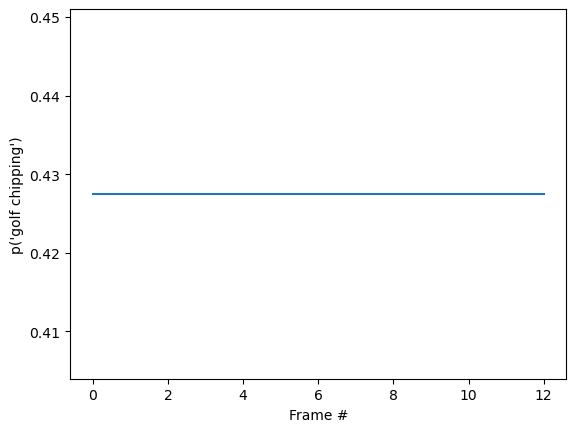

In [39]:
id = tf.argmax(probabilities[-1])
plt.plot(probabilities[:, id])
plt.xlabel('Frame #')
plt.ylabel(f"p('{KINETICS_600_LABELS[id]}')");

In [40]:
for label, p in get_top_k(tf.reduce_mean(probabilities, axis=0)):
  print(f'{label:20s}: {p:.3f}')

golf chipping       : 0.427
tackling            : 0.134
lunge               : 0.056
stretching arm      : 0.053
passing american football (not in game): 0.039


### Animate the predictions over time

In [41]:
# Get top_k labels and probabilities predicted using MoViNets streaming model
def get_top_k_streaming_labels(probs, k=5, label_map=KINETICS_600_LABELS):
  """Returns the top-k labels over an entire video sequence.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    k: the number of top predictions to select.
    label_map: a list of labels to map logit indices to label strings.

  Returns:
    a tuple of the top-k probabilities, labels, and logit indices
  """
  top_categories_last = tf.argsort(probs, -1, 'DESCENDING')[-1, :1]
  # Sort predictions to find top_k
  categories = tf.argsort(probs, -1, 'DESCENDING')[:, :k]
  categories = tf.reshape(categories, [-1])

  counts = sorted([
      (i.numpy(), tf.reduce_sum(tf.cast(categories == i, tf.int32)).numpy())
      for i in tf.unique(categories)[0]
  ], key=lambda x: x[1], reverse=True)

  top_probs_idx = tf.constant([i for i, _ in counts[:k]])
  top_probs_idx = tf.concat([top_categories_last, top_probs_idx], 0)
  # find unique indices of categories
  top_probs_idx = tf.unique(top_probs_idx)[0][:k+1]
  # top_k probabilities of the predictions
  top_probs = tf.gather(probs, top_probs_idx, axis=-1)
  top_probs = tf.transpose(top_probs, perm=(1, 0))
  # collect the labels of top_k predictions
  top_labels = tf.gather(label_map, top_probs_idx, axis=0)
  # decode the top_k labels
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]

  return top_probs, top_labels, top_probs_idx

# Plot top_k predictions at a given time step
def plot_streaming_top_preds_at_step(
    top_probs,
    top_labels,
    step=None,
    image=None,
    legend_loc='lower left',
    duration_seconds=10,
    figure_height=500,
    playhead_scale=0.8,
    grid_alpha=0.3):
  """Generates a plot of the top video model predictions at a given time step.

  Args:
    top_probs: a tensor of shape (k, num_frames) representing the top-k
      probabilities over all frames.
    top_labels: a list of length k that represents the top-k label strings.
    step: the current time step in the range [0, num_frames].
    image: the image frame to display at the current time step.
    legend_loc: the placement location of the legend.
    duration_seconds: the total duration of the video.
    figure_height: the output figure height.
    playhead_scale: scale value for the playhead.
    grid_alpha: alpha value for the gridlines.

  Returns:
    A tuple of the output numpy image, figure, and axes.
  """
  # find number of top_k labels and frames in the video
  num_labels, num_frames = top_probs.shape
  if step is None:
    step = num_frames
  # Visualize frames and top_k probabilities of streaming video
  fig = plt.figure(figsize=(6.5, 7), dpi=300)
  gs = mpl.gridspec.GridSpec(8, 1)
  ax2 = plt.subplot(gs[:-3, :])
  ax = plt.subplot(gs[-3:, :])
  # display the frame
  if image is not None:
    ax2.imshow(image, interpolation='nearest')
    ax2.axis('off')
  # x-axis (frame number)
  preview_line_x = tf.linspace(0., duration_seconds, num_frames)
  # y-axis (top_k probabilities)
  preview_line_y = top_probs

  line_x = preview_line_x[:step+1]
  line_y = preview_line_y[:, :step+1]

  for i in range(num_labels):
    ax.plot(preview_line_x, preview_line_y[i], label=None, linewidth='1.5',
            linestyle=':', color='gray')
    ax.plot(line_x, line_y[i], label=top_labels[i], linewidth='2.0')


  ax.grid(which='major', linestyle=':', linewidth='1.0', alpha=grid_alpha)
  ax.grid(which='minor', linestyle=':', linewidth='0.5', alpha=grid_alpha)

  min_height = tf.reduce_min(top_probs) * playhead_scale
  max_height = tf.reduce_max(top_probs)
  ax.vlines(preview_line_x[step], min_height, max_height, colors='red')
  ax.scatter(preview_line_x[step], max_height, color='red')

  ax.legend(loc=legend_loc)

  plt.xlim(0, duration_seconds)
  plt.ylabel('Probability')
  plt.xlabel('Time (s)')
  plt.yscale('log')

  fig.tight_layout()
  fig.canvas.draw()

  data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  plt.close()

  figure_width = int(figure_height * data.shape[1] / data.shape[0])
  image = PIL.Image.fromarray(data).resize([figure_width, figure_height])
  image = np.array(image)

  return image

# Plotting top_k predictions from MoViNets streaming model
def plot_streaming_top_preds(
    probs,
    video,
    top_k=5,
    video_fps=25.,
    figure_height=500,
    use_progbar=True):
  """Generates a video plot of the top video model predictions.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    video: the video to display in the plot.
    top_k: the number of top predictions to select.
    video_fps: the input video fps.
    figure_fps: the output video fps.
    figure_height: the height of the output video.
    use_progbar: display a progress bar.

  Returns:
    A numpy array representing the output video.
  """
  # select number of frames per second
  video_fps = 8.
  # select height of the image
  figure_height = 500
  # number of time steps of the given video
  steps = video.shape[0]
  # estimate duration of the video (in seconds)
  duration = steps / video_fps
  # estimate top_k probabilities and corresponding labels
  top_probs, top_labels, _ = get_top_k_streaming_labels(probs, k=top_k)

  images = []
  step_generator = tqdm.trange(steps) if use_progbar else range(steps)
  for i in step_generator:
    image = plot_streaming_top_preds_at_step(
        top_probs=top_probs,
        top_labels=top_labels,
        step=i,
        image=video[i],
        duration_seconds=duration,
        figure_height=figure_height,
    )
    images.append(image)

  return np.array(images)

In [42]:
init_states = model.init_states(jumpingjack[tf.newaxis].shape)

In [43]:
# Insert your video clip here
video = jumpingjack
images = tf.split(video[tf.newaxis], video.shape[0], axis=1)

all_logits = []

# To run on a video, pass in one frame at a time
states = init_states
for image in tqdm.tqdm(images):
  # predictions for each frame
  logits, states = model({**states, 'image': image})
  all_logits.append(logits)

# concatenating all the logits
logits = tf.concat(all_logits, 0)
# estimating probabilities
probs = tf.nn.softmax(logits, axis=-1)

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:00<00:00, 34.04it/s]


In [44]:
final_probs = probs[-1]
print('Top_k predictions and their probablities\n')
for label, p in get_top_k(final_probs):
  print(f'{label:20s}: {p:.3f}')

Top_k predictions and their probablities

jumping jacks       : 0.999
zumba               : 0.000
doing aerobics      : 0.000
dancing charleston  : 0.000
slacklining         : 0.000


In [45]:
# Generate a plot and output to a video tensor
plot_video = plot_streaming_top_preds(probs, video, video_fps=8.)

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:02<00:00,  4.63it/s]


In [46]:
# For gif format, set codec='gif'
media.show_video(plot_video, fps=5)

## MoViNet Tutorial and Finetuning

#### Install packages

In [ ]:
# tf-models-official is the stable Model Garden package
# tf-models-nightly includes latest changes
!pip install -U -q "tf-models-official"


# Install the mediapy package for visualizing images/videos.
# See https://github.com/google/mediapy
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy

#### Run imports

In [61]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import mediapy as media
import numpy as np
import PIL
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tqdm
import absl.logging

tf.get_logger().setLevel('ERROR')
absl.logging.set_verbosity(absl.logging.ERROR)
mpl.rcParams.update({
    'font.size': 10,
})

#### Helper code

In [69]:
# Download Kinetics 600 label map
file_path = "kinetics_600_labels.txt"
with open(file_path, 'r') as f:
    lines = f.readlines()
    KINETICS_600_LABELS_LIST = [line.strip() for line in lines]
    KINETICS_600_LABELS = tf.constant(KINETICS_600_LABELS_LIST)

def get_top_k(probs, k=5, label_map=KINETICS_600_LABELS):
  """Outputs the top k model labels and probabilities on the given video."""
  top_predictions = tf.argsort(probs, axis=-1, direction='DESCENDING')[:k]
  top_labels = tf.gather(label_map, top_predictions, axis=-1)
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]
  top_probs = tf.gather(probs, top_predictions, axis=-1).numpy()
  return tuple(zip(top_labels, top_probs))

def predict_top_k(model, video, k=5, label_map=KINETICS_600_LABELS):
  """Outputs the top k model labels and probabilities on the given video."""
  outputs = model.predict(video[tf.newaxis])[0]
  probs = tf.nn.softmax(outputs)
  return get_top_k(probs, k=k, label_map=label_map)

def load_movinet_from_hub(model_mode):
  """Loads a MoViNet model from TF Hub."""
  if model_mode == 'base':
    saved_model_path = 'saved_model'
    encoder = hub.KerasLayer(saved_model_path, trainable=True)
  else:
    saved_model_path = 'saved_model_2'
    encoder = hub.KerasLayer(saved_model_path, trainable=True)

  inputs = tf.keras.layers.Input(
      shape=[None, None, None, 3],
      dtype=tf.float32)

  if model_mode == 'base':
    inputs = dict(image=inputs)
  else:
    # Define the state inputs, which is a dict that maps state names to tensors.
    init_states_fn = encoder.resolved_object.signatures['init_states']
    state_shapes = {
        name: ([s if s > 0 else None for s in state.shape], state.dtype)
        for name, state in init_states_fn(tf.constant([0, 0, 0, 0, 3])).items()
    }
    states_input = {
        name: tf.keras.Input(shape[1:], dtype=dtype, name=name)
        for name, (shape, dtype) in state_shapes.items()
    }

    # The inputs to the model are the states and the video
    inputs = {**states_input, 'image': inputs}

  # Output shape: [batch_size, 600]
  outputs = encoder(inputs)

  model = tf.keras.Model(inputs, outputs)
  model.build([1, 1, 1, 1, 3])

  return model


# Download example gif
!wget https://github.com/tensorflow/models/raw/f8af2291cced43fc9f1d9b41ddbf772ae7b0d7d2/official/projects/movinet/files/jumpingjack.gif -O jumpingjack.gif -q

def load_gif(file_path, image_size=(224, 224)):
  """Loads a gif file into a TF tensor."""
  with tf.io.gfile.GFile(file_path, 'rb') as f:
    video = tf.io.decode_gif(f.read())
  video = tf.image.resize(video, image_size)
  video = tf.cast(video, tf.float32) / 255.
  return video

def get_top_k_streaming_labels(probs, k=5, label_map=KINETICS_600_LABELS_LIST):
  """Returns the top-k labels over an entire video sequence.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    k: the number of top predictions to select.
    label_map: a list of labels to map logit indices to label strings.

  Returns:
    a tuple of the top-k probabilities, labels, and logit indices
  """
  top_categories_last = tf.argsort(probs, -1, 'DESCENDING')[-1, :1]
  categories = tf.argsort(probs, -1, 'DESCENDING')[:, :k]
  categories = tf.reshape(categories, [-1])

  counts = sorted([
      (i.numpy(), tf.reduce_sum(tf.cast(categories == i, tf.int32)).numpy())
      for i in tf.unique(categories)[0]
  ], key=lambda x: x[1], reverse=True)

  top_probs_idx = tf.constant([i for i, _ in counts[:k]])
  top_probs_idx = tf.concat([top_categories_last, top_probs_idx], 0)
  top_probs_idx = tf.unique(top_probs_idx)[0][:k+1]

  top_probs = tf.gather(probs, top_probs_idx, axis=-1)
  top_probs = tf.transpose(top_probs, perm=(1, 0))
  top_labels = tf.gather(label_map, top_probs_idx, axis=0)
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]

  return top_probs, top_labels, top_probs_idx

def plot_streaming_top_preds_at_step(
    top_probs,
    top_labels,
    step=None,
    image=None,
    legend_loc='lower left',
    duration_seconds=10,
    figure_height=500,
    playhead_scale=0.8,
    grid_alpha=0.3):
  """Generates a plot of the top video model predictions at a given time step.

  Args:
    top_probs: a tensor of shape (k, num_frames) representing the top-k
      probabilities over all frames.
    top_labels: a list of length k that represents the top-k label strings.
    step: the current time step in the range [0, num_frames].
    image: the image frame to display at the current time step.
    legend_loc: the placement location of the legend.
    duration_seconds: the total duration of the video.
    figure_height: the output figure height.
    playhead_scale: scale value for the playhead.
    grid_alpha: alpha value for the gridlines.

  Returns:
    A tuple of the output numpy image, figure, and axes.
  """
  num_labels, num_frames = top_probs.shape
  if step is None:
    step = num_frames

  fig = plt.figure(figsize=(6.5, 7), dpi=300)
  gs = mpl.gridspec.GridSpec(8, 1)
  ax2 = plt.subplot(gs[:-3, :])
  ax = plt.subplot(gs[-3:, :])

  if image is not None:
    ax2.imshow(image, interpolation='nearest')
    ax2.axis('off')

  preview_line_x = tf.linspace(0., duration_seconds, num_frames)
  preview_line_y = top_probs

  line_x = preview_line_x[:step+1]
  line_y = preview_line_y[:, :step+1]

  for i in range(num_labels):
    ax.plot(preview_line_x, preview_line_y[i], label=None, linewidth='1.5',
            linestyle=':', color='gray')
    ax.plot(line_x, line_y[i], label=top_labels[i], linewidth='2.0')


  ax.grid(which='major', linestyle=':', linewidth='1.0', alpha=grid_alpha)
  ax.grid(which='minor', linestyle=':', linewidth='0.5', alpha=grid_alpha)

  min_height = tf.reduce_min(top_probs) * playhead_scale
  max_height = tf.reduce_max(top_probs)
  ax.vlines(preview_line_x[step], min_height, max_height, colors='red')
  ax.scatter(preview_line_x[step], max_height, color='red')

  ax.legend(loc=legend_loc)

  plt.xlim(0, duration_seconds)
  plt.ylabel('Probability')
  plt.xlabel('Time (s)')
  plt.yscale('log')

  fig.tight_layout()
  fig.canvas.draw()

  data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  plt.close()

  figure_width = int(figure_height * data.shape[1] / data.shape[0])
  image = PIL.Image.fromarray(data).resize([figure_width, figure_height])
  image = np.array(image)

  return image, (fig, ax, ax2)

def plot_streaming_top_preds(
    probs,
    video,
    top_k=5,
    video_fps=25.,
    figure_height=500,
    use_progbar=True):
  """Generates a video plot of the top video model predictions.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    video: the video to display in the plot.
    top_k: the number of top predictions to select.
    video_fps: the input video fps.
    figure_fps: the output video fps.
    figure_height: the height of the output video.
    use_progbar: display a progress bar.

  Returns:
    A numpy array representing the output video.
  """
  video_fps = 8.
  figure_height = 500
  steps = video.shape[0]
  duration = steps / video_fps

  top_probs, top_labels, _ = get_top_k_streaming_labels(probs, k=top_k)

  images = []
  step_generator = tqdm.trange(steps) if use_progbar else range(steps)
  for i in step_generator:
    image, _ = plot_streaming_top_preds_at_step(
        top_probs=top_probs,
        top_labels=top_labels,
        step=i,
        image=video[i],
        duration_seconds=duration,
        figure_height=figure_height,
    )
    images.append(image)

  return np.array(images)

zsh:1: command not found: wget


#### Running Base Model Inference with TensorFlow Hub

In [68]:
saved_model_path = 'saved_model'
model = hub.load(saved_model_path)

In [70]:
video = load_gif('jumpingjack.gif', image_size=(172, 172))

# Show video
print(video.shape)
media.show_video(video.numpy(), fps=5)

(13, 172, 172, 3)


In [ ]:
# Run the model on the video and output the top 5 predictions
outputs = predict_top_k(model, video)

for label, prob in outputs:
  print(label, prob)

#### Run Streaming Model Inference with TensorFlow Hub and Plot Predictions

In [ ]:
model = load_movinet_from_hub('a2', 'stream', hub_version=3)

# Create initial states for the stream model
init_states_fn = model.layers[-1].resolved_object.signatures['init_states']
init_states = init_states_fn(tf.shape(video[tf.newaxis]))

In [ ]:
# Insert your video clip here
video = load_gif('jumpingjack.gif', image_size=(172, 172))
clips = tf.split(video[tf.newaxis], video.shape[0], axis=1)

all_logits = []

# To run on a video, pass in one frame at a time
states = init_states
for clip in tqdm.tqdm(clips):
  # Input shape: [1, 1, 172, 172, 3]
  logits, states = model.predict({**states, 'image': clip}, verbose=0)
  all_logits.append(logits)

logits = tf.concat(all_logits, 0)
probs = tf.nn.softmax(logits)

final_probs = probs[-1]
top_k = get_top_k(final_probs)
print()
for label, prob in top_k:
  print(label, prob)

In [ ]:
# Generate a plot and output to a video tensor
plot_video = plot_streaming_top_preds(probs, video, video_fps=8.)

In [ ]:
# For gif format, set codec='gif'
media.show_video(plot_video, fps=3)

### Export a Streaming Model to TensorFlow Lite for Mobile

In [ ]:
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model
from official.projects.movinet.tools import export_saved_model

In [ ]:
model_id = 'a0'
use_positional_encoding = model_id in {'a3', 'a4', 'a5'}

# Create backbone and model.
backbone = movinet.Movinet(
    model_id=model_id,
    causal=True,
    conv_type='2plus1d',
    se_type='2plus3d',
    activation='hard_swish',
    gating_activation='hard_sigmoid',
    use_positional_encoding=use_positional_encoding,
    use_external_states=True,
)

model = movinet_model.MovinetClassifier(
    backbone,
    num_classes=600,
    output_states=True)

# Create your example input here.
# Refer to the paper for recommended input shapes.
inputs = tf.ones([1, 13, 172, 172, 3])

# [Optional] Build the model and load a pretrained checkpoint.
model.build(inputs.shape)


# Extract pretrained weights
!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_stream.tar.gz -O movinet_a0_stream.tar.gz -q
!tar -xvf movinet_a0_stream.tar.gz

checkpoint_dir = 'movinet_a0_stream'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

In [ ]:
# Export to saved model
saved_model_dir = 'model'
tflite_filename = 'model.tflite'
input_shape = [1, 1, 172, 172, 3]

# Convert to saved model
export_saved_model.export_saved_model(
    model=model,
    input_shape=input_shape,
    export_path=saved_model_dir,
    causal=True,
    bundle_input_init_states_fn=False)

In [ ]:
# Convert to TF Lite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open(tflite_filename, 'wb') as f:
  f.write(tflite_model)

# Create the interpreter and signature runner
interpreter = tf.lite.Interpreter(model_path=tflite_filename)
runner = interpreter.get_signature_runner()

init_states = {
    name: tf.zeros(x['shape'], dtype=x['dtype'])
    for name, x in runner.get_input_details().items()
}
del init_states['image']

In [ ]:
# Insert your video clip here
video = load_gif('jumpingjack.gif', image_size=(172, 172))
clips = tf.split(video[tf.newaxis], video.shape[0], axis=1)

# To run on a video, pass in one frame at a time
states = init_states
for clip in clips:
  # Input shape: [1, 1, 172, 172, 3]
  outputs = runner(**states, image=clip)
  logits = outputs.pop('logits')[0]
  states = outputs

probs = tf.nn.softmax(logits)
top_k = get_top_k(probs)
print()
for label, prob in top_k:
  print(label, prob)

### Fine-Tune a Base Model with the TensorFlow Model Garden

#### Load the UCF-101 Dataset with TensorFlow Datasets

In [ ]:
# Run imports
import tensorflow_datasets as tfds

from official.vision.configs import video_classification
from official.projects.movinet.configs import movinet as movinet_configs
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_layers
from official.projects.movinet.modeling import movinet_model

In [ ]:
dataset_name = 'ucf101'

builder = tfds.builder(dataset_name)

config = tfds.download.DownloadConfig(verify_ssl=False)
builder.download_and_prepare(download_config=config)

In [ ]:
num_classes = builder.info.features['label'].num_classes
num_examples = {
    name: split.num_examples
    for name, split in builder.info.splits.items()
}

print('Number of classes:', num_classes)
print('Number of examples for train:', num_examples['train'])
print('Number of examples for test:', num_examples['test'])
print()

builder.info

In [ ]:
# Build the training and evaluation datasets.

batch_size = 8
num_frames = 8
frame_stride = 10
resolution = 172

def format_features(features):
  video = features['video']
  video = video[:, ::frame_stride]
  video = video[:, :num_frames]

  video = tf.reshape(video, [-1, video.shape[2], video.shape[3], 3])
  video = tf.image.resize(video, (resolution, resolution))
  video = tf.reshape(video, [-1, num_frames, resolution, resolution, 3])
  video = tf.cast(video, tf.float32) / 255.

  label = tf.one_hot(features['label'], num_classes)
  return (video, label)

train_dataset = builder.as_dataset(
    split='train',
    batch_size=batch_size,
    shuffle_files=True)
train_dataset = train_dataset.map(
    format_features,
    num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.prefetch(2)

test_dataset = builder.as_dataset(
    split='test',
    batch_size=batch_size)
test_dataset = test_dataset.map(
    format_features,
    num_parallel_calls=tf.data.AUTOTUNE,
    deterministic=True)
test_dataset = test_dataset.prefetch(2)

In [ ]:
videos, labels = next(iter(train_dataset))
media.show_videos(videos.numpy(), codec='gif', fps=5)

#### Build MoViNet-A0-Base and Load Pretrained Weights

In [ ]:
model_id = 'a0'

tf.keras.backend.clear_session()

backbone = movinet.Movinet(model_id=model_id)
model = movinet_model.MovinetClassifier(backbone=backbone, num_classes=600)
model.build([1, 1, 1, 1, 3])

# Load pretrained weights
!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_base.tar.gz -O movinet_a0_base.tar.gz -q
!tar -xvf movinet_a0_base.tar.gz

checkpoint_dir = 'movinet_a0_base'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

def build_classifier(backbone, num_classes, freeze_backbone=False):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
  model.build([batch_size, num_frames, resolution, resolution, 3])

  if freeze_backbone:
    for layer in model.layers[:-1]:
      layer.trainable = False
    model.layers[-1].trainable = True

  return model

# Wrap the backbone with a new classifier to create a new classifier head
# with num_classes outputs (101 classes for UCF101).
# Freeze all layers except for the final classifier head.
model = build_classifier(backbone, num_classes, freeze_backbone=True)

In [ ]:
num_epochs = 3

train_steps = num_examples['train'] // batch_size
total_train_steps = train_steps * num_epochs
test_steps = num_examples['test'] // batch_size

loss_obj = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True,
    label_smoothing=0.1)

metrics = [
    tf.keras.metrics.TopKCategoricalAccuracy(
        k=1, name='top_1', dtype=tf.float32),
    tf.keras.metrics.TopKCategoricalAccuracy(
        k=5, name='top_5', dtype=tf.float32),
]

initial_learning_rate = 0.01
learning_rate = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps=total_train_steps,
)
optimizer = tf.keras.optimizers.RMSprop(
    learning_rate, rho=0.9, momentum=0.9, epsilon=1.0, clipnorm=1.0)

model.compile(loss=loss_obj, optimizer=optimizer, metrics=metrics)

callbacks = [
    tf.keras.callbacks.TensorBoard(),
]

In [ ]:
results = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=num_epochs,
    steps_per_epoch=train_steps,
    validation_steps=test_steps,
    callbacks=callbacks,
    validation_freq=1,
    verbose=1)

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs --port 0

## Video Classification with a CNN-RNN Architecture

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

### Data Collection

In [ ]:
!!wget -q https://github.com/sayakpaul/Action-Recognition-in-TensorFlow/releases/download/v1.0.0/ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

### Setup

In [ ]:
import os

import keras
from imutils import paths

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio
import cv2
from IPython.display import Image

### Define hyperparameters

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

### Data preparation

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

In [ ]:
# The following two methods are taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub


def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [ ]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

In [ ]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

In [ ]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = keras.ops.convert_to_numpy(label_processor(labels[..., None]))

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(
            shape=(
                1,
                MAX_SEQ_LENGTH,
            ),
            dtype="bool",
        )
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :], verbose=0,
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

### The sequence model

In [ ]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier/ckpt.weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

### Inference

In [ ]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(
        shape=(
            1,
            MAX_SEQ_LENGTH,
        ),
        dtype="bool",
    )
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, duration=100)
    return Image("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

# Code

Finally, here is a code for video classification that uses MoViNet and finetuning :

### Step 1: Load and Preprocess Data

In [83]:
from moviepy.editor import *

# Define your list of activities
activities = ["bicyclecrunch", "birddog", "fly", "legraise", "curl", "armraise", "pushup", "superman", "overheadpress", "squat"]

# Function to load labels
def load_labels(labels_path, activities):
    lines = labels_path.read_text().splitlines()
    labels = [line.strip() for line in lines]
    matching_labels = [activity for activity in activities if activity in labels]
    
    # If an activity is not found in the labels file, add it anyway
    for activity in activities:
        if activity not in matching_labels:
            matching_labels.append(activity)
            
    return np.array(matching_labels)

# Load the labels for the specified activities
KINETICS_ACTIVITIES = load_labels(labels_path, activities)
print(KINETICS_ACTIVITIES, "\n")

# Read and process a video
def load_video(file_path, image_size=(224, 224), num_frames=5):
    """Loads a video file (MP4) into a TF tensor.

    Resize the frames to match the specified image size.

    Args:
        file_path: Path to the location of an MP4 video file.
        image_size: A tuple of the target size for each frame.
        num_frames: Number of frames to keep from the video.

    Returns:
        A video tensor of the MP4 file.
    """
    # Load a gif file, convert it to a TF tensor
    raw = tf.io.read_file(file_path)
    video = tf.io.decode_gif(raw)
    # Resize the video
    video = tf.image.resize(video, image_size)
    # change dtype to a float32
    # Hub models always want images normalized to [0,1]
    # ref: https://www.tensorflow.org/hub/common_signatures/images#input
    video = tf.cast(video, tf.float32) / 255.
    return video

# Convert video to a gif
def convert_to_gif(input_path, output_path):
    clip = VideoFileClip(input_path)
    clip.write_gif(output_path)

# Example usage:
input_path = os.getcwd() + '/FitnessBasic/squat/data/000076.mp4'
output_path = os.getcwd() + '/output3/squat/000076.gif'
convert_to_gif(input_path, output_path)
video = load_video(output_path)
video.shape

['squat' 'bicyclecrunch' 'birddog' 'fly' 'legraise' 'curl' 'armraise'
 'pushup' 'superman' 'overheadpress'] 

MoviePy - Building file /Users/Matthieu/Desktop/Project/output3/squat/000076.gif with imageio.


TensorShape([396, 224, 224, 3])

### Step 2: Build MoViNet Model

In [84]:
def load_movinet_from_hub(model_mode):
    """Loads a MoViNet model from TF Hub."""
    if model_mode == 'base':
        saved_model_path = 'saved_model'
        encoder = hub.KerasLayer(saved_model_path, trainable=True)
    else:
        saved_model_path = 'saved_model_2'
        encoder = hub.KerasLayer(saved_model_path, trainable=True)

    inputs = tf.keras.layers.Input(
        shape=[None, None, None, 3],
        dtype=tf.float32)

    if model_mode == 'base':
        inputs = dict(image=inputs)
    else:
        # Define the state inputs, which is a dict that maps state names to tensors.
        init_states_fn = encoder.resolved_object.signatures['init_states']
        state_shapes = {
            name: ([s if s > 0 else None for s in state.shape], state.dtype)
            for name, state in init_states_fn(tf.constant([0, 0, 0, 0, 3])).items()
        }
        states_input = {
            name: tf.keras.Input(shape[1:], dtype=dtype, name=name)
            for name, (shape, dtype) in state_shapes.items()
        }

        # The inputs to the model are the states and the video
        inputs = {**states_input, 'image': inputs}

    # Output shape: [batch_size, 600]
    outputs = encoder(inputs)

    model = tf.keras.Model(inputs, outputs)
    model.build([1, 1, 1, 1, 3])

    return model

### Step 3: Train MoViNet Model (to adapt)

In [85]:
# Load the dataset
df = pd.read_csv("keypoints_data_movenet.csv")

# Extract input sequences (keypoints) and labels
input_sequences = []
labels = []

for index, row in df.iterrows():
    # Extract keypoints for the current video
    keypoints_columns = [col for col in df.columns if col not in ["Video ID", "Frame", "Label"]]
    
    # Concatenate keypoints from all columns into a single sequence
    sequence = []
    for col in keypoints_columns:
        sequence.extend([row[col]])
        
    # Append the input sequence
    input_sequences.append(sequence)
    
    # Append the label
    labels.append(row["Label"])

# Convert input_sequences to numpy array
X_train = np.array(input_sequences)

# Reshape X_train for the CNN model
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Train-Test split the data
X_train, X_test, y_train, y_test = train_test_split(X_train_reshaped, labels, test_size=0.33, random_state=1)

# Convert y_train to numpy array if it's not already
y_train = np.array(y_train)

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the input sequences
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=1)

# Design the CNN model
model = Sequential([
    layers.Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.GlobalAveragePooling1D(), 
    layers.Dense(len(activities), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Epoch 1/20
5728/5728 [==============================] - 16s 3ms/step - loss: 1.3594 - accuracy: 0.4429 - val_loss: 1.1431 - val_accuracy: 0.5372
Epoch 2/20
5728/5728 [==============================] - 16s 3ms/step - loss: 1.0310 - accuracy: 0.5899 - val_loss: 0.9816 - val_accuracy: 0.6162
Epoch 3/20
5728/5728 [==============================] - 17s 3ms/step - loss: 0.8643 - accuracy: 0.6653 - val_loss: 0.7994 - val_accuracy: 0.6922
Epoch 4/20
5728/5728 [==============================] - 15s 3ms/step - loss: 0.7578 - accuracy: 0.7097 - val_loss: 0.7259 - val_accuracy: 0.7199
Epoch 5/20
5728/5728 [==============================] - 14s 3ms/step - loss: 0.6858 - accuracy: 0.7400 - val_loss: 0.6552 - val_accuracy: 0.7509
Epoch 6/20
5728/5728 [==============================] - 14s 2ms/step - loss: 0.6310 - accuracy: 0.7630 - val_loss: 0.6435 - val_accuracy: 0.7600
Epoch 7/20
5728/5728 [==============================] - 15s 3ms/step - loss: 0.5919 - accuracy: 0.7791 - val_loss: 0.6170 - val_ac

ValueError: Failed to find data adapter that can handle input: <class 'numpy.ndarray'>, (<class 'list'> containing values of types {"<class 'int'>"})

### Step 4: Inference (to adapt)

In [ ]:
# Define function to preprocess single video frames
def preprocess_single_video(video_frames):
    # Resize and preprocess frames (assuming frames are already loaded)
    resized_frames = [cv2.resize(frame, (224, 224)) for frame in video_frames]
    preprocessed_frames = np.array(resized_frames) / 255.0  # Normalize
    return preprocessed_frames

# Load a test video
test_video_path = "path_to_test_video.mp4"
cap = cv2.VideoCapture(test_video_path)
frames = []

# Read frames from the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)

cap.release()

# Preprocess test video frames
preprocessed_test_video = preprocess_single_video(frames)

# Perform inference using trained MoViNet model
predicted_class_probabilities = movinet_model.predict(preprocessed_test_video)

# Get the predicted class
predicted_class_index = np.argmax(predicted_class_probabilities)
predicted_class = KINETICS_ACTIVITIES[predicted_class_index]

print(f"Predicted Class: {predicted_class}")

### Discussion

For obvious reasons, we will not be able to report and discuss on our results for part 3. However, it would be interesting to develop on what we would expect to happen and what the results would look like. If everything worked as intended, when training the MoViNet model, we would expect a decent accuracy of 80% or higher, which can be considered good performance for activity recognition. Then, when using the inference algorithm on a video of a person doing a certain fitness activity, i.e. overhead press, it is likely that the model identifies the activity as overhead press. 

# Task 4: Model Comparison

In comparing the results of the three models, we observe variations in their accuracies and performances. Model 1, utilizing both CNN and LSTM architectures, demonstrates solid performance, with the CNN model achieving an accuracy of approximately 85.26% and the LSTM model achieving around 81.42%. While the LSTM model shows slightly lower accuracy, it exhibits better generalization as evidenced by its higher validation accuracy of 86.97%.

Moving to Model 2, which incorporates biomechanical features, we note a significant disparity in accuracy compared to Model 1. The version utilizing only biomechanical features yields a substantially lower accuracy of approximately 61.69%, indicating the limitations of relying solely on these features for activity recognition. However, with the inclusion of additional significant features, the accuracy improves significantly to approximately 83.79%, nearing the performance of Model 1.

Regarding Model 3, centered around MoViNet, we can only speculate on its performance. Based on expectations and typical outcomes, we anticipate achieving a decent accuracy exceeding 80% and hopefully a satisfying generalization.

Overall, while Model 1 demonstrates strong performance leveraging both CNN and LSTM architectures, Model 2 highlights the importance of feature selection and augmentation in improving accuracy. Although Model 3 remains speculative, its potential for achieving high accuracy and robust activity recognition warrants further exploration and validation.